# Reaching the precision limit with tensor-based wavefront shaping: Supplementary information

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.patches import FancyArrowPatch, ArrowStyle
import numpy as np
import os
from scipy.linalg import orth
import scipy.stats as stats
from pyTen.decompositions import get_HOSvec, hosvd, als3herm, als4herm2, als

from pyFisher.fisher_functions import get_W3, get_W4, normalizevecs,\
    getOutputFields,  fisher, get_oopms, get_fish_oopms
from pyFisher.optimize_fisher import optimize_inputNopms

from functions import colorize, rnd_cpx_disk, norm_inner, cpx_corr
from functions import norm_qqplot

In [3]:
# Define default plotting options
%matplotlib inline

zf = 1 # zoom factor
lw = zf*2 # line width 
ms = zf*4 # marker size

SMALL_SIZE = 7*zf
MEDIUM_SIZE = 8*zf
BIGGER_SIZE = 9*zf

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica') 
plt.rc('figure', facecolor='white') # white background for VSC

cmap_int = 'gray'
cmap_fish = 'inferno'
cmisv = matplotlib.cm.get_cmap('Oranges')
cmrnd = matplotlib.cm.get_cmap('Purples')
cmmod = matplotlib.cm.get_cmap('Blues')
cmmiic = matplotlib.cm.get_cmap('Reds')
crnd = cmrnd(1.)
cmod = cmmod(0.8)
cisv = cmisv(0.7)
cmiic = cmmiic(0.8)

fig_path = os.path.abspath(os.path.join('Figures','SI'))


# 1. Load data and parameter definition

In [4]:
data_path = os.path.abspath('Data')

# Load TM at rest in the pixel basis
TMpix = np.load(os.path.join(data_path,'TMpix.npy'))
# Load TMs for mode computation
TMs4modes = np.load(os.path.join(data_path,'TMs4modes.npy'))
dz4modes = 2 # um
# Load TMs and deformations values for larger deformations
TMs_large_def = np.load(os.path.join(data_path,'TMs_large_def.npy'))
dz_large_def = np.load(os.path.join(data_path,'dz_large_def.npy'))

# Define number of output modes and modes of the fiber
N_out = int(np.shape(TMs4modes)[-2]**(1/2))
n_mod = np.shape(TMs4modes)[-1]

# Load intensity measurments used for the estimation
int_sc = (0.2/0.45)**2
dz4der = 3.00264
I4der = np.load(os.path.join(data_path,'I4der.npy'))
I4der_lowI = np.load(os.path.join(data_path,'I4der_lowI.npy'))
I4ref = np.load(os.path.join(data_path,'I4ref.npy'))
I4est = np.load(os.path.join(data_path,'I4est.npy'))
dz4est = np.load(os.path.join(data_path,'dz4est.npy'))

# To plot output fields
def plot_field(field, ax=None, cpx=False, **kwargs):
    sh = (N_out,N_out)
    if cpx:
        field2p = colorize(np.reshape(field, sh))
    else :
        field2p = np.reshape(field, sh)
    if ax is None:
        ax = plt.gca()
    ax.axis('off')
    return ax.imshow(field2p, **kwargs)

# 2. Choosing the input modes: SVD at rest

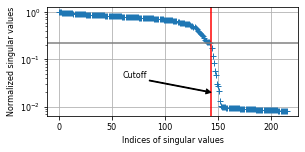

In [30]:
u, s, vh = np.linalg.svd(TMpix)
fig,ax = plt.subplots(1, 1,figsize=(zf*4.5,zf*2))
ax.semilogy((s[:int(n_mod*1.5)]/s[0]),'+')
ax.axvline(n_mod-.5,c='r')
ax.axhline((s[n_mod-1]/s[0]),c='gray')
ax.grid(True)
ax.set_xlabel('Indices of singular values')
ax.set_ylabel('Normalized singular values')
ax.annotate('Cutoff', xy=(n_mod-.5,2e-2), xytext=(n_mod/2, 4e-2), horizontalalignment='center',
            fontsize=MEDIUM_SIZE, arrowprops=dict(facecolor='black',width=0.8,headlength=5,headwidth=5))

fig.savefig(os.path.join(fig_path,'svd_pix.pdf'),bbox_inches='tight')

# 3. Noise characterization

To have an initial idea of the noise dependence in our system we first plot the mean and standard deviation of the intensity distribution over the output pixels for each input field and for high and low input total input intensities:

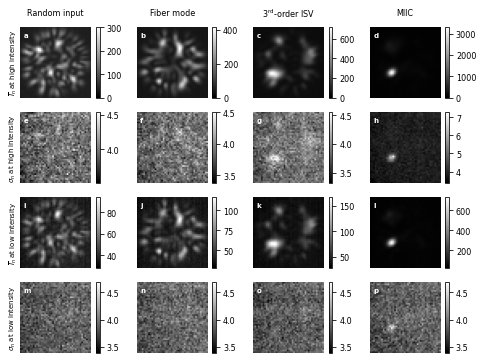

In [34]:
fig, axs = plt.subplots(4,4, figsize=(zf*8.,zf*6))
nb_lb = [['a','b','c','d'],['e','f','g','h'],['i','j','k','l']
,['m','n','o','p']]
ylbls = ['$\overline{I}_n$ at high intensity','$\sigma_n$ at high intensity',
         '$\overline{I}_n$ at low intensity','$\sigma_n$ at low intensity']
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'MIIC']

vmin_std_high = np.min(np.std(I4der[0], axis=0))
vmax_std_high = np.max(np.std(I4der[0], axis=0))

vmin_std_low = np.min(np.std(I4der_lowI[0], axis=0))
vmax_std_low = np.max(np.std(I4der_lowI[0], axis=0))
for ind_f in range(4):
    intp = plot_field(np.mean(I4der[0,:,ind_f], axis=0), axs[0,ind_f],
                      cmap=cmap_int,vmin=0)
    
    stdp = plot_field(np.std(I4der[0,:,ind_f], axis=0), axs[1,ind_f],
                      cmap=cmap_int)#,vmin=vmin_std_high, vmax=vmax_std_high)
    
    fig.colorbar(intp, ax= axs[0,ind_f])
    fig.colorbar(stdp, ax= axs[1,ind_f])

    intp = plot_field(np.mean(I4der_lowI[0,:,ind_f], axis=0), axs[2,ind_f],
                      cmap=cmap_int)
    stdp = plot_field(np.std(I4der_lowI[0,:,ind_f], axis=0), axs[3,ind_f],
                      cmap=cmap_int,vmin=vmin_std_low,vmax=vmax_std_low)#,vmin=vmin_nll,vmax=vmax_nll)
    
    fig.colorbar(intp, ax= axs[2,ind_f])
    fig.colorbar(stdp, ax= axs[3,ind_f])
    
    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    for i2 in range(4):
        axs[i2,ind_f].text(0.05,0.85,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, 
                           color='w', fontweight='bold')
        if ind_f==0:
            axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
                horizontalalignment='center', fontsize=SMALL_SIZE,
                verticalalignment='center', rotation=90)

for ax in axs.ravel():
    ax.axis('off')

plt.savefig(os.path.join(fig_path,'Inoise.pdf'),bbox_inches='tight')

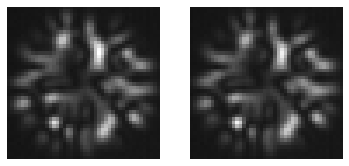

In [14]:
i_f = 1
fig, axs = plt.subplots(1,2)
I2p = np.mean(I4der[:,:,i_f], axis=1)
vmax = np.max(I2p)
plot_field(I2p[0], axs[0],
                      cmap=cmap_int,vmin=0,vmax=vmax)
plot_field(I2p[-1], axs[1],
                      cmap=cmap_int,vmin=0,vmax=vmax)

While this indicates that at lower intensities the noise no longer depends on the specific intensity value, it is not a proof that the noise does follow a Gaussian distribution. To verify this assumption, we use all the data points and generate quantile-quantile plots.

In [5]:
IdiffsL = I4est - np.mean(I4est, axis=1, keepdims=True)
IdiffsH = I4der - np.mean(I4der, axis=1, keepdims=True)

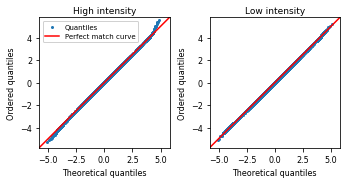

In [25]:
fig, axs = plt.subplots(1,2, figsize=(zf*0.8*7.,zf*0.8*3))
norm_qqplot(IdiffsH[0,:,:,:].ravel(), skipn=1000, ax=axs[0], marker="o", s=ms)
norm_qqplot(IdiffsL[0,:,:,:].ravel(), skipn=1000, ax=axs[1], marker="o", s=ms, lgd=False)
for i, lbl in enumerate(['High intensity', 'Low intensity']):
    axs[i].text(0.5,1.05, lbl, transform = axs[i].transAxes,
        horizontalalignment='center', fontsize=BIGGER_SIZE,
        verticalalignment='center', rotation=0)
    

plt.savefig(os.path.join(fig_path,'qqplot.pdf'),bbox_inches='tight')

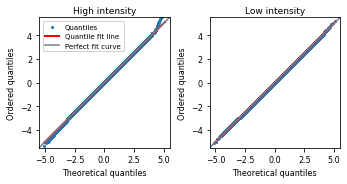

In [5]:
fig, axs = plt.subplots(1,2, figsize=(zf*0.8*7.,zf*0.8*3))
norm_qqplot(IdiffsH[0,:,:,:].ravel(), ax=axs[0], marker="o", s=ms)
norm_qqplot(IdiffsL[0,:,:,:].ravel(), ax=axs[1], marker="o", s=ms, lgd=False)
for i, lbl in enumerate(['High intensity', 'Low intensity']):
    axs[i].text(0.5,1.05, lbl, transform = axs[i].transAxes,
        horizontalalignment='center', fontsize=BIGGER_SIZE,
        verticalalignment='center', rotation=0)
    

plt.savefig(os.path.join(fig_path,'qqplot.pdf'),bbox_inches='tight')

# 4. Need for higher intensity calibration

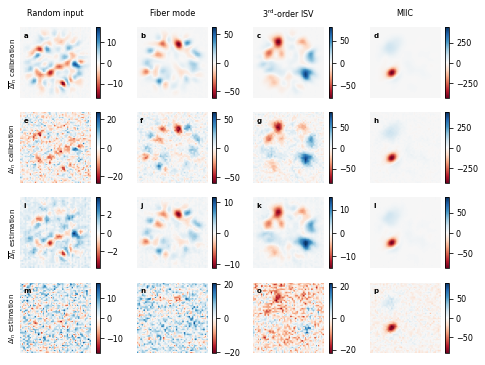

In [26]:
fig, axs = plt.subplots(4,4, figsize=(zf*8,zf*6))
Idiffs_amps = I4der[1]-I4der[0]
Idiffs_ampsl = I4der_lowI[1]-I4der_lowI[0]

vm_h = np.max(np.abs(np.mean(Idiffs_amps, axis=0)), axis=-1)
vs_h = np.max(np.abs(Idiffs_amps[0]), axis=-1)
vm_l = np.max(np.abs(np.mean(Idiffs_ampsl, axis=0)), axis=-1)
vs_l = np.max(np.abs(Idiffs_ampsl[0]), axis=-1)

ylbls = ['$\overline{\Delta I}_n$ calibration', '$\Delta I_n$ calibration',
         '$\overline{\Delta I}_n$ estimation', '$\Delta I_n$ estimation']
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'MIIC']
nb_lb = [['a','b','c','d'],['e','f','g','h'],['i','j','k','l']
,['m','n','o','p']]

for ind_f in range(4):
    intp = plot_field(np.mean(Idiffs_amps[:,ind_f], axis=0), axs[0,ind_f],
                        cmap='RdBu', vmin = -vm_h[ind_f], vmax= vm_h[ind_f])
    fig.colorbar(intp, ax= axs[0,ind_f])

    intp = plot_field(Idiffs_amps[0,ind_f], axs[1,ind_f],
                        cmap='RdBu', vmin = -vs_h[ind_f], vmax= vs_h[ind_f])
    fig.colorbar(intp, ax= axs[1,ind_f])

    intl = plot_field(np.mean(Idiffs_ampsl[:,ind_f], axis=0), axs[2,ind_f],
                        cmap='RdBu', vmin = -vm_l[ind_f], vmax= vm_l[ind_f])
    fig.colorbar(intl, ax= axs[2,ind_f])
    
    intl = plot_field(Idiffs_ampsl[0,ind_f], axs[3,ind_f],
                        cmap='RdBu', vmin = -vs_l[ind_f], vmax= vs_l[ind_f])
    fig.colorbar(intl, ax= axs[3,ind_f])
    
    axs[0,ind_f].text(0.5,1.2, labels[ind_f],transform = axs[0,ind_f].transAxes,
     horizontalalignment='center', fontsize=MEDIUM_SIZE,
     verticalalignment='center', rotation=0)
    for i2 in range(4):
        axs[i2,ind_f].text(0.05,0.85,nb_lb[i2][ind_f], transform=axs[i2,ind_f].transAxes, color='black', fontweight='bold')
        if ind_f==0:
            axs[i2,ind_f].text(-0.1,0.5, ylbls[i2],transform = axs[i2,ind_f].transAxes,
                horizontalalignment='center', fontsize=SMALL_SIZE,
                verticalalignment='center', rotation=90)
for ax in axs.ravel():
    ax.axis('off')


plt.savefig(os.path.join(fig_path,'IchgVpixI.pdf'),bbox_inches='tight')

# Estimating with low intensity calibration

In [47]:
# Function for computing the estimation
def estimate_def(Imeas, Iref0, Ider):
    return np.sum(Ider * (Imeas - Iref0), axis=-1)/np.sum(Ider**2, axis=-1)

In [48]:
Iders = int_sc * np.mean(I4der[1]-I4der[0], axis=0)/dz4der
Idersl = np.mean(I4der_lowI[1]-I4der_lowI[0], axis=0)/dz4der
Irefs = np.mean(I4ref, axis=0)

def_estimates = estimate_def(I4est, Irefs, Iders)
std_def = np.mean(np.std(def_estimates, axis=1),axis=0)
def_estimates_l = estimate_def(I4est, Irefs, Idersl)
std_def_l = np.mean(np.std(def_estimates_l, axis=1),axis=0)

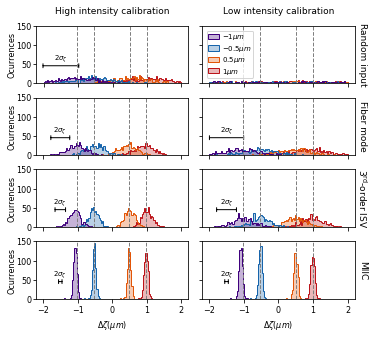

In [76]:
fig, axs = plt.subplots(4,2,figsize=(zf*5,zf*4.5))
labels = ['Random input', 'Fiber mode', '3${}^\mathregular{rd}$-order ISV', 'MIIC']
alpha = 0.3
# define colors for histograms
chist = [crnd, cmod, cisv, cocc]
cf = []
for i in range(len(chist)):
    cf +=  [(*matplotlib.colors.to_rgb(chist[i]),alpha)]

# ranges for histograms
y_lim = 150
xmin = np.round(dz4est[0])-1
xmax = np.round(dz4est[-1])+1
bins = np.linspace(xmin,xmax,120)
# arrow stye and pos for std_def
y_arrow = y_lim*0.3
x_arrow = -1.5#target_def_list[-1]
style = ArrowStyle('|-|',widthA=2.0*zf,widthB=2.0*zf)#, head_length=4, head_width=1.5)
    
for ip in range(4):

    if ip<3:
        axs[ip,0].axes.xaxis.set_ticklabels([])

    axs[ip,0].set_ylim(0,y_lim)
    
    axs[3,0].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = def_estimates[:,:,ip].T
    axs[ip,0].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[ip,0].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')

    std_arrow = FancyArrowPatch((x_arrow-std_def[ip],y_arrow),
                                (x_arrow+std_def[ip],y_arrow),
                                shrinkA = 0, shrinkB = 0, color='black', lw=lw,
                                arrowstyle=style)
    axs[ip,0].add_patch(std_arrow)
    axs[ip,0].text(x_arrow,y_arrow+0.1*y_lim, r'$2\sigma_\zeta$', 
                   fontweight='bold', horizontalalignment='center')

    for n in range(len(dz4est)):
        axs[ip,0].axvline(x=dz4est[n], c='gray',linewidth=lw, ls='--')

    # axs[ip,1].set_box_aspect(1/2.4)
    axs[ip,0].set_xticks(np.arange(xmin,xmax+1,1))
    axs[ip,0].set_ylabel('Ocurrences')
    axs[ip,0].get_yaxis().labelpad = -0.
    axs[ip,0].yaxis.set_tick_params(pad=1)


    axs[ip,1].axes.yaxis.set_ticklabels([])
    if ip<3:
        axs[ip,1].axes.xaxis.set_ticklabels([])

    axs[ip,1].set_ylim(0,y_lim)
    
    axs[3,1].set_xlabel('$\Delta \zeta (\mu m)$')
    xvar = def_estimates_l[:,:,ip].T
    axs[ip,1].hist(xvar, bins, color=chist, histtype='step',lw=lw)
    axs[ip,1].hist(xvar, bins, color=chist, alpha=alpha,  histtype='stepfilled')
    
    if ip != 0:
        std_arrow = FancyArrowPatch((x_arrow-std_def_l[ip],y_arrow),
                                    (x_arrow+std_def_l[ip],y_arrow),
                                    shrinkA = 0, shrinkB = 0, color='black', lw=lw,
                                    arrowstyle=style)
        axs[ip,1].add_patch(std_arrow)
        axs[ip,1].text(x_arrow,y_arrow+0.1*y_lim, r'$2\sigma_\zeta$', 
                    fontweight='bold', horizontalalignment='center')

    for n in range(len(dz4est)):
        axs[ip,1].axvline(x=dz4est[n], c='gray',linewidth=lw, ls='--')

    axs[ip,1].text(1.05,0.5, labels[ip],transform = axs[ip,1].transAxes,
     horizontalalignment='center', fontsize=BIGGER_SIZE,
     verticalalignment='center', rotation=270)

handles = [matplotlib.patches.Rectangle((0,0),.01,.01,color=cf[i],ec=chist[i]) for i in range(4)]
labels= ["$-1\mu m$","$-0.5\mu m$", "$0.5\mu m$",'$1\mu m$']
fig.legend(handles, labels, fontsize=SMALL_SIZE, ncol=1, loc=(0.55,0.77), 
           frameon=True, handleheight=.8,
           handlelength=1.5, labelspacing=0.2, columnspacing=0.2,handletextpad=0.5,
           borderpad=0.2)

for i, lbl in enumerate(['High intensity calibration', 'Low intensity calibration']):
    axs[0,i].text(0.5,1.25, lbl, transform = axs[0,i].transAxes,
        horizontalalignment='center', fontsize=BIGGER_SIZE,
        verticalalignment='center', rotation=0)

plt.tight_layout(pad=0., w_pad=1.5, h_pad=0.8)


plt.savefig(os.path.join(fig_path,'est_hVSl_plot.pdf'),bbox_inches='tight')